# Time Series Analysis (TSA) in Python - Linear Models to GARCH
[Source](https://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016)

---------------------------

**Before we begin let's import our Python libraries.**

In [1]:
import os
import sys
import platform

import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA

import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

# # For linux environment only
# p('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
# p(sys.version)
# For other environment
print('Machine: {} {} {}\n'.format(
    platform.uname().system, platform.uname().machine, platform.uname().version
))
print(sys.version)

Machine: Windows AMD64 10.0.22621

3.10.11 | packaged by Anaconda, Inc. | (main, Apr 20 2023, 18:56:50) [MSC v.1916 64 bit (AMD64)]


In [2]:
platform.uname()

uname_result(system='Windows', node='Jacesca', release='10', version='10.0.22621', machine='AMD64')

**Let's use the pandas_datareader package to grab some sample data using the Yahoo Finance API.**

In [3]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.get_data_yahoo(x, start=start, end=end)['Adj Close']
symbols = ['SPY','TLT','MSFT']

# raw adjusted close prices
yf.pdr_override() 
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
data

,SPY,TLT,MSFT
Date,,,
2007-01-03,102.625740,55.019806,21.525984
2007-01-04,102.843536,55.353416,21.489941
2007-01-05,102.023224,55.112480,21.367380
2007-01-08,102.495087,55.211319,21.576441
2007-01-09,102.408005,55.211319,21.598070
...,...,...,...
2014-12-24,178.140945,102.487823,41.819469
2014-12-26,178.715393,102.868141,41.593613
2014-12-29,178.955460,103.637100,41.220074


In [5]:
# log returns
lrets = np.log(data/data.shift(1)).dropna()
lrets

,SPY,TLT,MSFT
Date,,,
2007-01-04,0.002120,0.006045,-0.001676
2007-01-05,-0.008008,-0.004362,-0.005719
2007-01-08,0.004614,0.001792,0.009737
2007-01-09,-0.000850,0.000000,0.001002
2007-01-10,0.003326,-0.004486,-0.010064
...,...,...,...
2014-12-24,0.000096,0.005428,-0.006419
2014-12-26,0.003219,0.003704,-0.005415
2014-12-29,0.001342,0.007447,-0.009021


**White Noise and Random Walks**

In [6]:
def tsplot(y, lags=None, figsize=(16, 6), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, method='ywm', ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

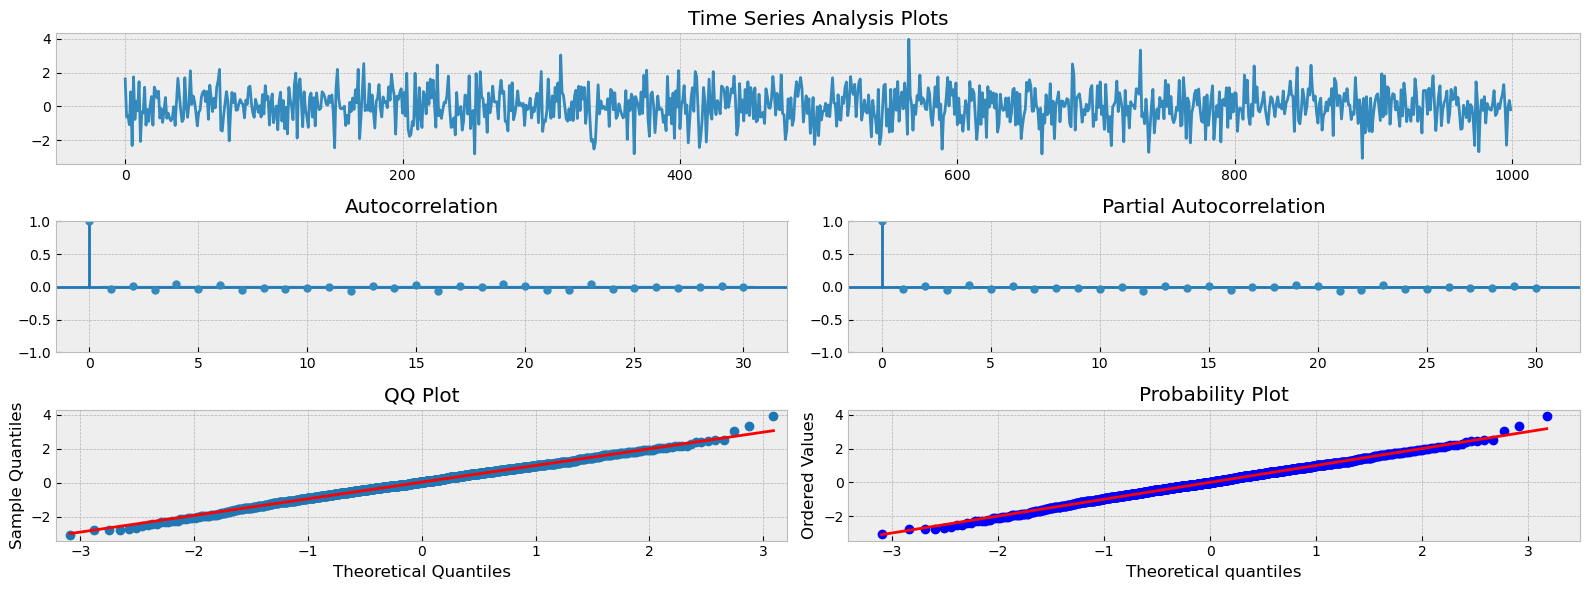

In [7]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

We can see that process appears to be random and centered about zero. The autocorrelation (ACF) and partial autocorrelation (PACF) plots also indicate no significant serial correlation. Keep in mind we should see approximately 5% significance in the autocorrelation plots due to pure chance as a result of sampling from the Normal distribution. Below that we can see the QQ and Probability Plots, which compares the distribution of our data with another theoretical distribution. In this case, that theoretical distribution is the standard normal distribution. Clearly our data is distributed randomly, and appears to follow Gaussian (Normal) white noise, as it should. 

In [8]:
print(
    "Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
    .format(randser.mean(), randser.var(), randser.std())
)

Random Series
 -------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


A Random Walk is defined below:
> Random Walk <br>
    > A random walk is a time series model $ x_t $ such that $ x_t = x_{t-1} + w_t $, where $ w_t $ is a discrete white noise series.

The significance of a random walk is that it is non-stationary because the covariance between observations is time-dependent. If the TS we are modeling is a random walk it is unpredictable.

Let's simulate a random walk using the **"np.random.normal(size=our_sample_size)"** function to sample from the standard normal distribution. 

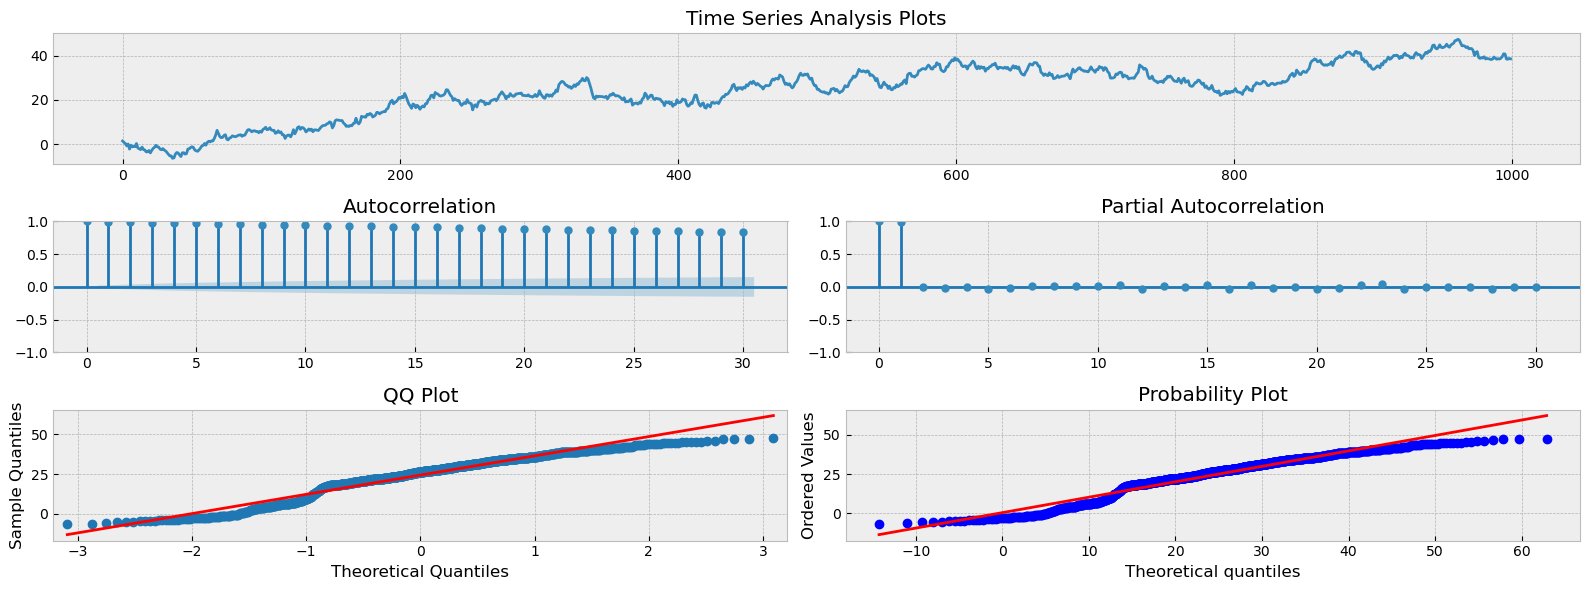

In [9]:
# Random Walk without a drift
np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

tsplot(x, lags=30)

Clearly our TS is not stationary. Let's find out if the random walk model is a good fit for our simulated data. Recall that a random walk is $ x_t = x_{t-1} + w_t $. Using algebra we can say that $ x_t - x_{t-1} = w_t $. Thus the first differences of our random walk series should equal a white noise process! We can use the **"np.diff()"** function on our TS and see if this holds. 

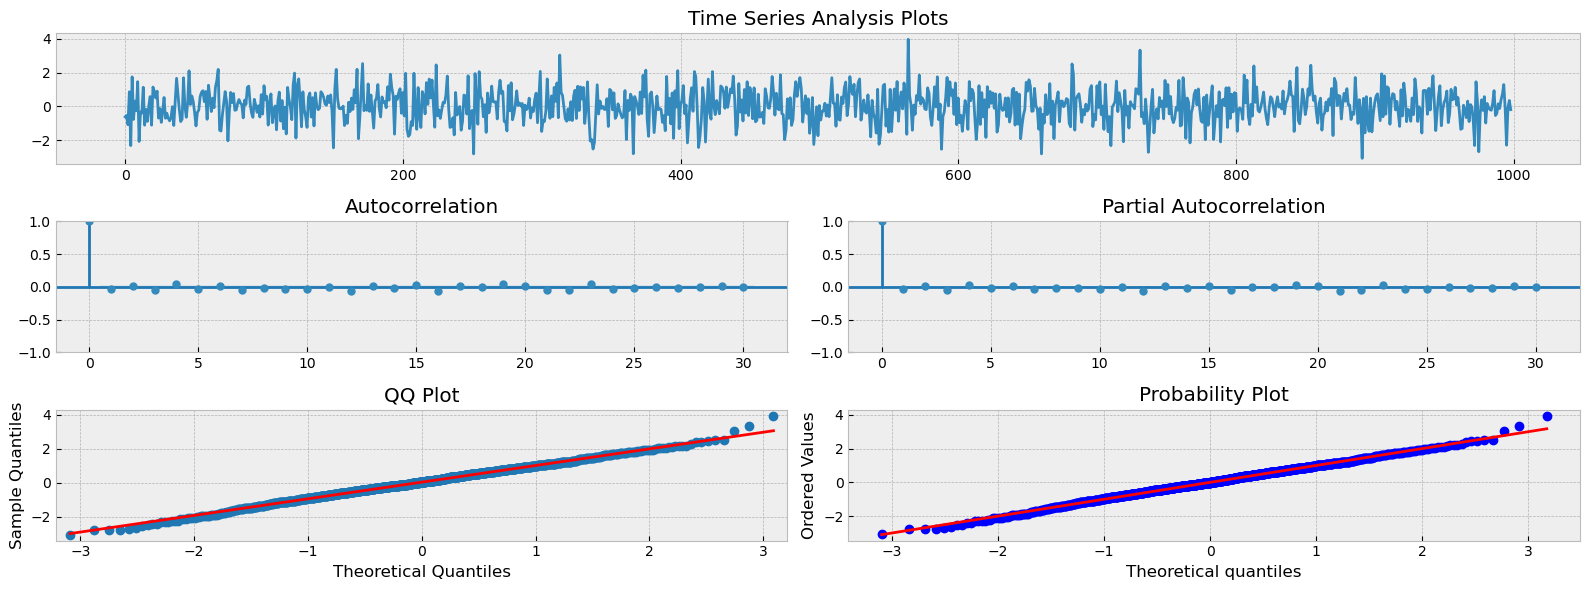

In [10]:
# First difference of simulated Random Walk series
# Calculate the n-th discrete difference along the given axis.
tsplot(np.diff(x), lags=30)

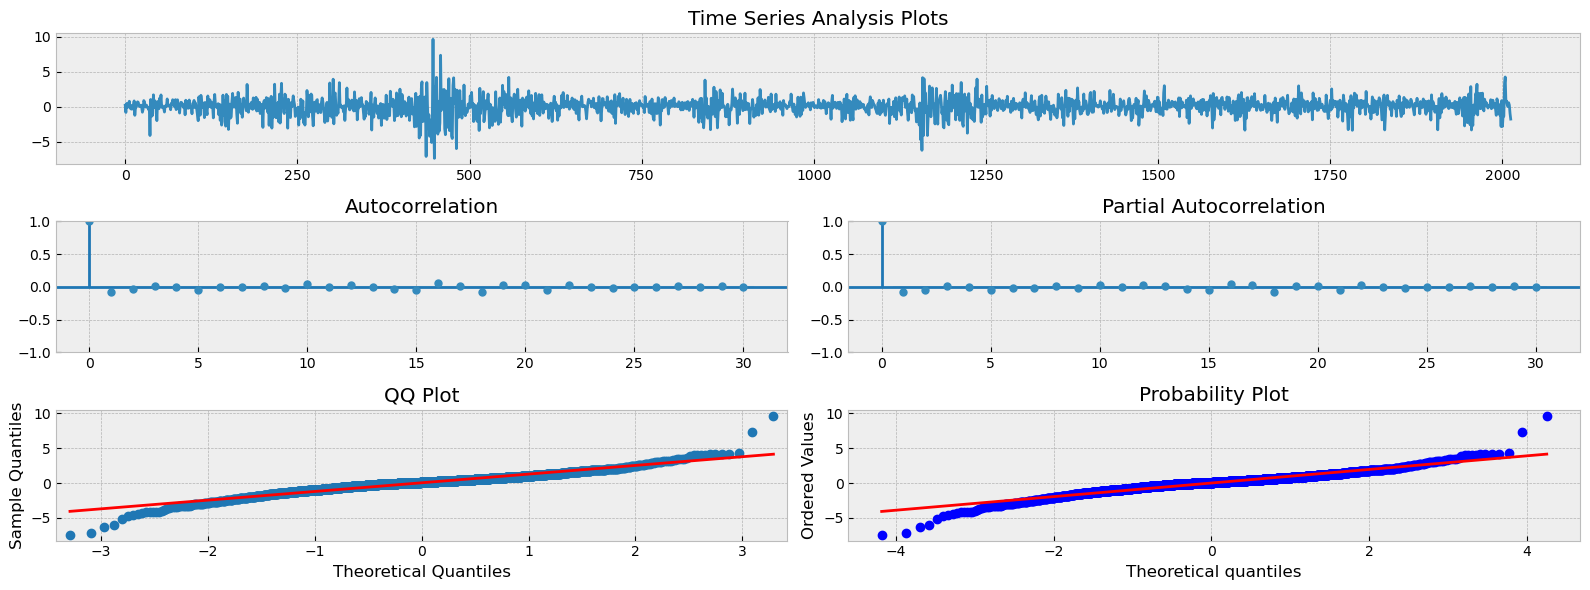

In [11]:
# First difference of SPY prices
tsplot(np.diff(data.SPY), lags=30)

Wow, it's quite similar to white noise. However, notice the shape of the QQ and Probability plots. This indicates that the process is close to normality but with 'heavy tails'. There also appears to be some significant serial correlation in the ACF, and PACF plots around lags 1, 5?, 16?, 18 and 21. This means that there should be better models to describe the actual price change process. 

### Linear Models

Linear models aka trend models represent a TS that can be graphed using a straight line. The basic equation is:
$$ y_t = b_0 + b_1t + \epsilon_t $$

In this model the value of the dependent variable is determined by the beta coefficients and a singular independent variable, time. An example could be a company's sales that increase by the same amount at each time step.  Let's look at a contrived example below. In this simulation we assume Firm ABC sales regardless of time are -$50.00 (beta 0 or the intercept term) and +$25.00 (beta 1) at every time step. 

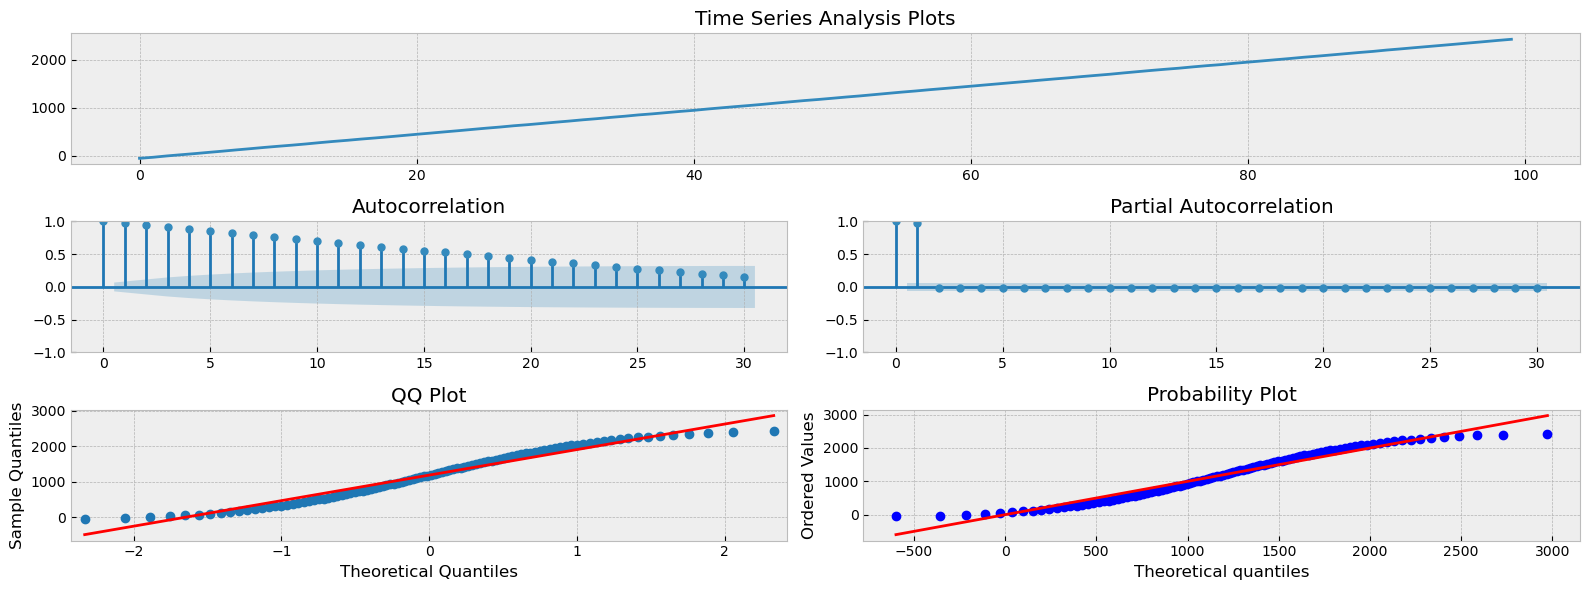

In [12]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
tsplot(y, lags=30) 

Here we can see that the residuals of the model are correlated and linearly decreasing as a function of the lag. The distribution is approximately normal. Before using this model to make predictions we would have to account for and remove the obvious autocorrelation present in the series. The significance of the PACF at lag 1 indicates that an autoregressive model may be appropriate.

### Log-Linear Models

These models are similar to linear models except that the data points form an exponential function that represent a constant rate of change with respect to each time step. For example, firm ABC's sales increasing X% at each time step. When plotting the simulated sales data you get a curve that looks like this:

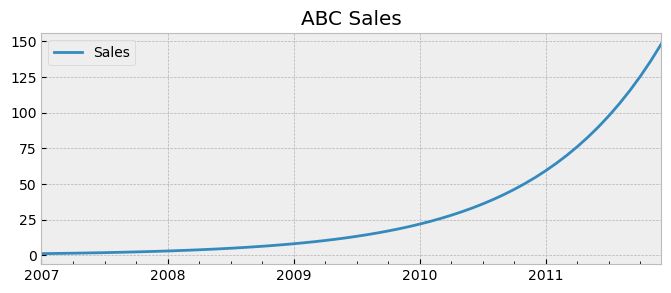

In [13]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    df.plot(ax=ax)
    plt.title('ABC Sales')
    plt.show()

**We can then transform the data by taking the natural logarithm of sales. Now a linear regression is a much better fit to the data.**

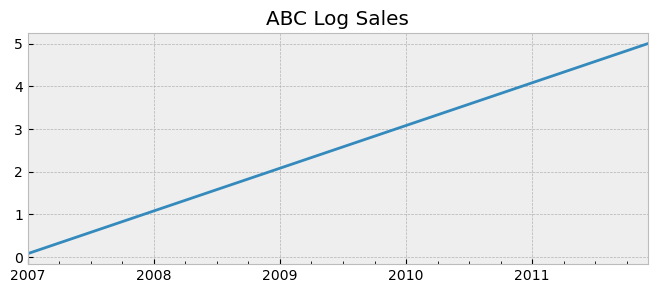

In [14]:
# ABC log sales 
with plt.style.context('bmh'):
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    pd.Series(np.log(sales), index=idx).plot(ax=ax)
    plt.title('ABC Log Sales')

These models have a fatal weakness as discussed previously. They assume serially UNcorrelated errors, which as we have seen in the linear model example is not true. In real life, TS data usually violates our stationary assumptions which motivates our progression to autoregressive models.

### Autoregressive Models - AR(p)

When the dependent variable is regressed against one or more lagged values of itself the model is called **autoregressive**. The formula looks like this:
$ x_t = \alpha_1x_{t-1} + ... + \alpha_p x_{t-p} + \omega_t $

$     = \sum_{i=1}^p \alpha_t x_{t-i} + \omega_t $ 

When you describe the "**order**" of the model, as in, an AR model of order "p", the p represents the number of lagged variables used within the model. For example an **AR(2)** model or second-order autoregressive model looks like this:

$ x_t = \alpha_1 x_{t-1} + \alpha_2 x_{t-2} + \omega_t $

Here, alpha ($ \alpha $) is the coefficient, and omega ($ \omega $) is a white noise term. Alpha cannot equal zero in an AR model. Note that an AR(1) model with alpha set equal to 1 is a random walk and therefore not stationary. 

$ x_t = \alpha_1 x_{t-1} + \omega_t $

Let's simulate an **AR(1)** model with alpha ($ \alpha $) set equal to 0.6

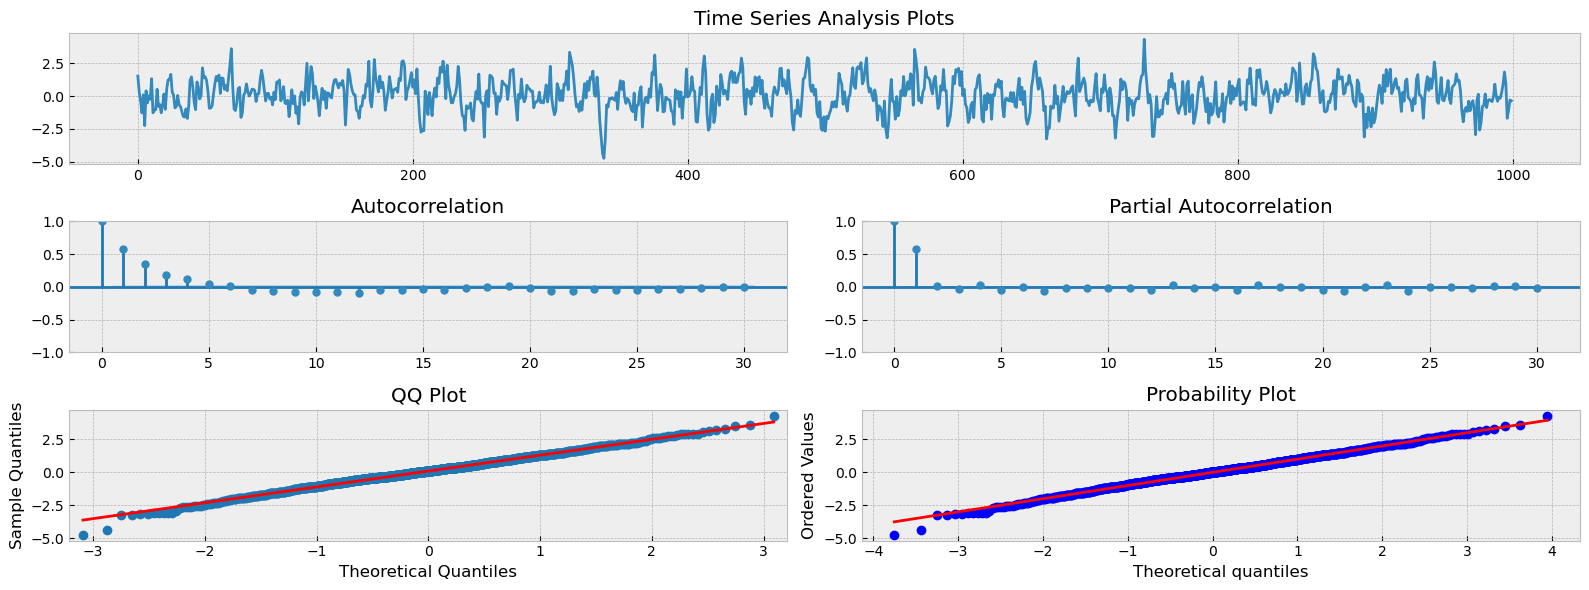

In [15]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
alpha = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = alpha*x[t-1] + w[t]
    
tsplot(x, lags=30)

As expected the distribution of our simulated **AR(1)** model is normal. There is significant serial correlation between lagged values especially at lag 1 as evidenced by the PACF plot. 

Now we can fit an AR(p) model using Python's statsmodels. First we fit the AR model to our simulated data and return the estimated alpha coefficient. Then we use the statsmodels function "select_order()" to see if the fitted model will select the correct lag. If the AR model is correct the estimated alpha coefficient will be close to our true alpha of 0.6 and the selected order will equal 1.

In [16]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6
mdl = AutoReg(x, 13).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                    AutoReg(13)   Log Likelihood               -1371.540
Method:               Conditional MLE   S.D. of innovations              0.971
Date:                Thu, 29 Jun 2023   AIC                           2773.080
Time:                        14:53:41   BIC                           2846.500
Sample:                            13   HQIC                          2801.002
                                 1000                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0501      0.031      1.596      0.110      -0.011       0.112
y.L1           0.5825      0.032     18.315      0.000       0.520       0.645
y.L2           0.0165      0.037      0.449      0.654      -0.055       0.088
y.L3          -0.0424      0.037     -1.159      0.247      -0.114       0.029
y.L4           0.0510      0.037      1.389      0.165      -0.021       0.123
y.L5          -0.0338      0.037     -0.919      0.358      -0.106       0.038
y.L6           0.0219      0.037      0.596      0.551      -0.050       0.094
y.L7          -0.0470      0.037     -1.281      0.200      -0.119       0.025
y.L8           0.0041      0.037      0.113      0.910      -0.068       0.076
y.L9          -0.0159      0.037     -0.435      0.663      -0.088       0.056
y.L10         -0.0145      0.036     -0.399      0.690      -0.086       0.057
y.L11          0.0201      0.036      0.551      0.582      -0.051       0.091
y.L12         -0.0686      0.036     -1.882      0.060      -0.140       0.003
y.L13          0.0363      0.032      1.148      0.251      -0.026       0.098
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.1962           -0.2885j            1.2305           -0.4623
AR.2            -1.1962           +0.2885j            1.2305            0.4623
AR.3            -0.8605           -0.9057j            1.2493           -0.3709
AR.4            -0.8605           +0.9057j            1.2493            0.3709
AR.5            -0.3032           -1.2398j            1.2764           -0.2882
AR.6            -0.3032           +1.2398j            1.2764            0.2882
AR.7             0.3472           -1.2229j            1.2712           -0.2060
AR.8             0.3472           +1.2229j            1.2712            0.2060
AR.9             0.8955           -0.9402j            1.2984           -0.1289
AR.10            0.8955           +0.9402j            1.2984            0.1289
AR.11            1.1506           -0.3434j            1.2008           -0.0462
AR.12            1.1506           +0.3434j            1.2008            0.0462
AR.13            1.8202           -0.0000j            1.8202           -0.0000
------------------------------------------------------------------------------
"""

In [17]:
est_order = ar_select_order(x, 30, old_names=False)
true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[1], est_order.ar_lags))
print('\ntrue alpha = {} | true order = {}'.format(alpha, true_order))


alpha estimate: 0.58251 | best lag order = [1]

true alpha = 0.6 | true order = 1


Looks like we were able to recover the underlying parameters of our simulated data. Let's simulate an AR(2) process with alpha_1 = 0.666 and alpha_2 = -0.333. For this we make use of statsmodel's "arma_generate_samples()" function. This function allows us to simulate an AR model of arbitrary orders. Note that there are some peculiarities of Python's version which requires us to take some extra steps before using the function.

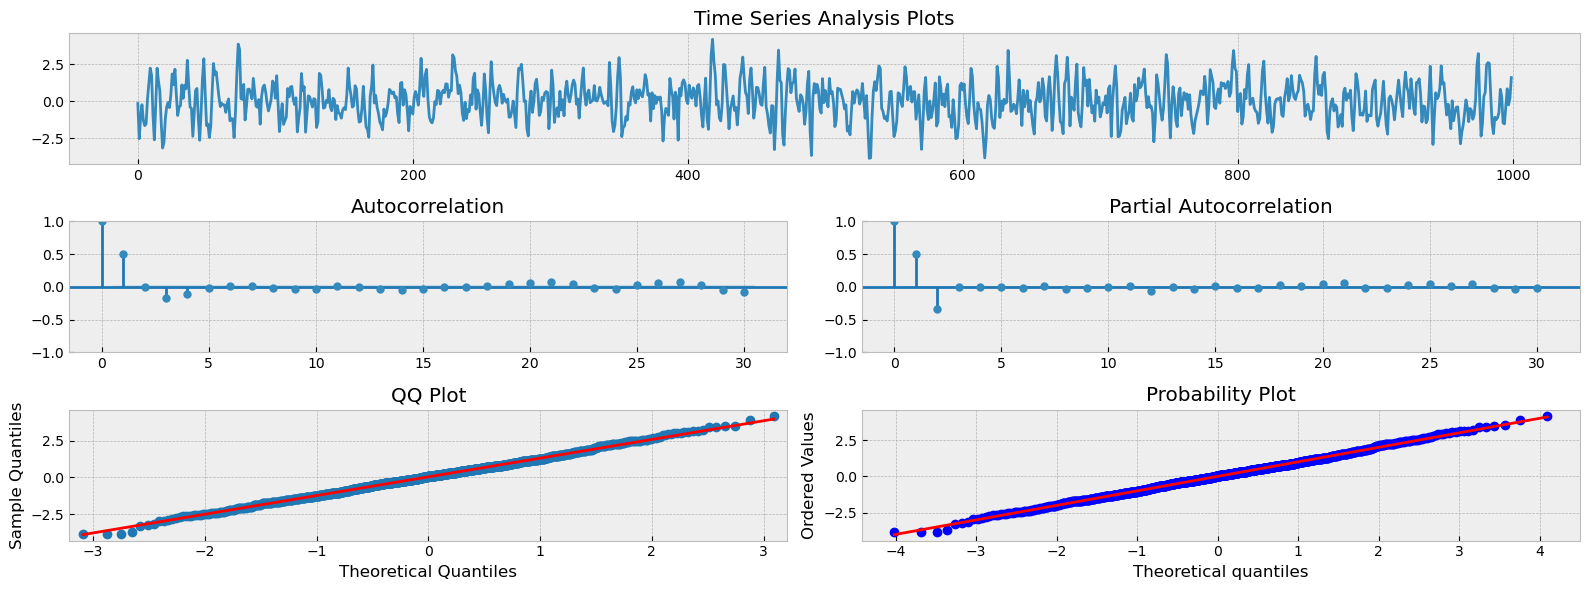

In [18]:
# Simulate an AR(2) process
n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
tsplot(ar2, lags=30)

**Let's see if we can recover the correct parameters.**

In [19]:
# Fit an AR(p) model to simulated AR(2) process
mdl = AutoReg(ar2, 13).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                    AutoReg(13)   Log Likelihood               -1425.136
Method:               Conditional MLE   S.D. of innovations              1.025
Date:                Thu, 29 Jun 2023   AIC                           2880.271
Time:                        14:53:43   BIC                           2953.691
Sample:                            13   HQIC                          2908.193
                                 1000                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0359      0.033      1.092      0.275      -0.028       0.100
y.L1           0.6748      0.032     21.202      0.000       0.612       0.737
y.L2          -0.3423      0.038     -8.923      0.000      -0.417      -0.267
y.L3           0.0084      0.040      0.211      0.833      -0.070       0.087
y.L4          -0.0131      0.040     -0.328      0.743      -0.091       0.065
y.L5           0.0227      0.040      0.570      0.568      -0.055       0.101
y.L6          -0.0466      0.040     -1.169      0.243      -0.125       0.032
y.L7           0.0320      0.040      0.803      0.422      -0.046       0.110
y.L8          -0.0267      0.040     -0.670      0.503      -0.105       0.051
y.L9          -0.0069      0.040     -0.173      0.863      -0.085       0.071
y.L10         -0.0321      0.040     -0.807      0.420      -0.110       0.046
y.L11          0.0519      0.040      1.303      0.192      -0.026       0.130
y.L12         -0.0508      0.038     -1.326      0.185      -0.126       0.024
y.L13         -0.0059      0.032     -0.187      0.852      -0.068       0.056
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.2067           -0.3536j            1.2574           -0.0454
AR.2             1.2067           +0.3536j            1.2574            0.0454
AR.3             0.9415           -0.8572j            1.2733           -0.1175
AR.4             0.9415           +0.8572j            1.2733            0.1175
AR.5             0.5074           -1.1298j            1.2385           -0.1828
AR.6             0.5074           +1.1298j            1.2385            0.1828
AR.7            -0.1122           -1.2459j            1.2509           -0.2643
AR.8            -0.1122           +1.2459j            1.2509            0.2643
AR.9            -0.8269           -1.0106j            1.3058           -0.3591
AR.10           -0.8269           +1.0106j            1.3058            0.3591
AR.11           -1.2278           -0.4222j            1.2984           -0.4473
AR.12           -1.2278           +0.4222j            1.2984            0.4473
AR.13           -9.5529           -0.0000j            9.5529           -0.5000
------------------------------------------------------------------------------
"""

In [20]:
est_order = ar_select_order(ar2, 30, old_names=False)
true_order = 2
print('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'.format(
    mdl.params[1], mdl.params[2], est_order.ar_lags))
print('\ntrue coefs = {} | true order = {}'.format([.666, -.333], true_order))


coef estimate: 0.6748 -0.3423 | best lag order = [1, 2]

true coefs = [0.666, -0.333] | true order = 2


**Not bad. Let's see how the AR(p) model will fit MSFT log returns. Here is the return TS.**

In [21]:
data.MSFT.head()

Date
2007-01-03    21.525984
2007-01-04    21.489941
2007-01-05    21.367380
2007-01-08    21.576441
2007-01-09    21.598070
Name: MSFT, dtype: float64

In [22]:
lrets.MSFT.head()

Date
2007-01-04   -0.001676
2007-01-05   -0.005719
2007-01-08    0.009737
2007-01-09    0.001002
2007-01-10   -0.010064
Name: MSFT, dtype: float64

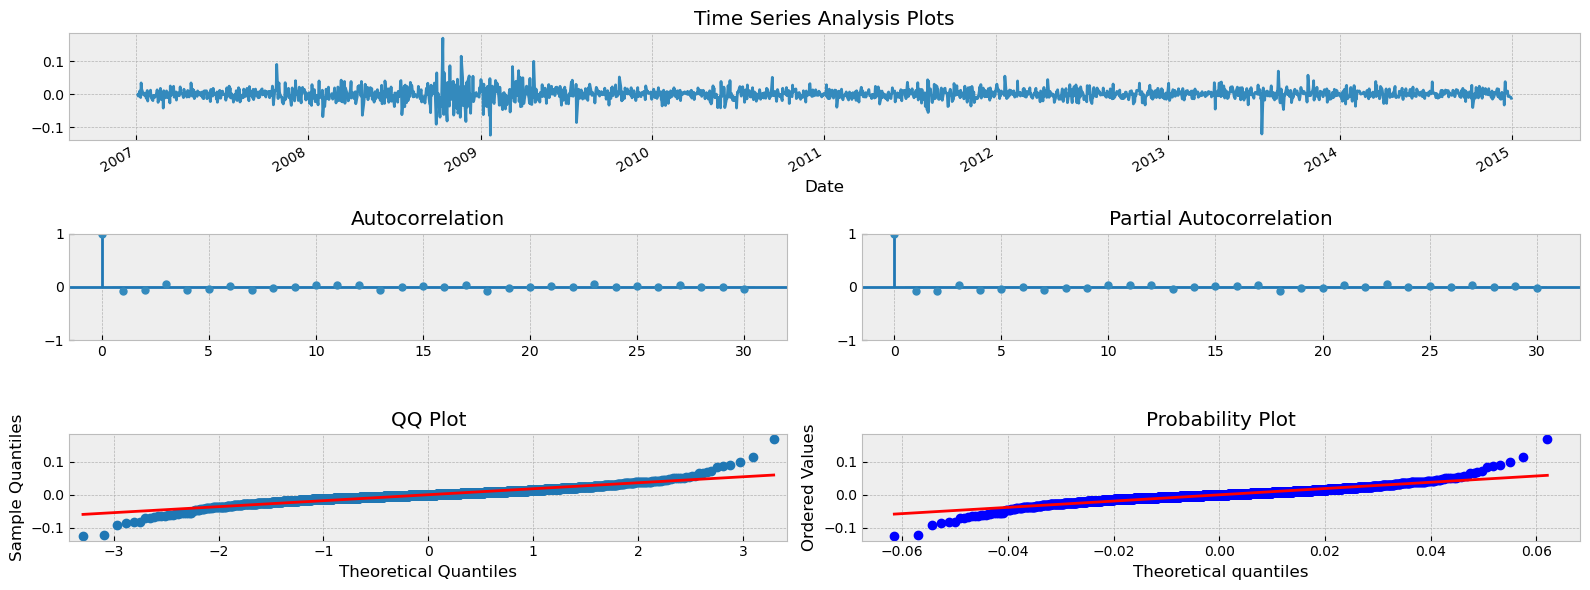

In [23]:
tsplot(lrets.MSFT, lags=30)

In [24]:
# Select best lag order for MSFT returns
mdl = AutoReg(lrets.MSFT.values, 13).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                 2013
Model:                    AutoReg(13)   Log Likelihood                5198.024
Method:               Conditional MLE   S.D. of innovations              0.018
Date:                Thu, 29 Jun 2023   AIC                         -10366.047
Time:                        14:53:44   BIC                         -10282.034
Sample:                            13   HQIC                        -10335.199
                                 2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.932      0.351      -0.000       0.001
y.L1          -0.0786      0.022     -3.520      0.000      -0.122      -0.035
y.L2          -0.0692      0.022     -3.088      0.002      -0.113      -0.025
y.L3           0.0295      0.022      1.315      0.189      -0.014       0.073
y.L4          -0.0651      0.022     -2.903      0.004      -0.109      -0.021
y.L5          -0.0399      0.022     -1.777      0.076      -0.084       0.004
y.L6          -0.0022      0.022     -0.099      0.921      -0.046       0.042
y.L7          -0.0538      0.022     -2.398      0.016      -0.098      -0.010
y.L8          -0.0210      0.022     -0.933      0.351      -0.065       0.023
y.L9          -0.0202      0.022     -0.898      0.369      -0.064       0.024
y.L10          0.0430      0.022      1.918      0.055      -0.001       0.087
y.L11          0.0430      0.022      1.917      0.055      -0.001       0.087
y.L12          0.0320      0.022      1.427      0.154      -0.012       0.076
y.L13         -0.0431      0.022     -1.926      0.054      -0.087       0.001
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.2220           -0.0000j            1.2220           -0.5000
AR.2            -1.1043           -0.6371j            1.2748           -0.4167
AR.3            -1.1043           +0.6371j            1.2748            0.4167
AR.4            -0.7007           -1.0070j            1.2268           -0.3468
AR.5            -0.7007           +1.0070j            1.2268            0.3468
AR.6            -0.1810           -1.2282j            1.2415           -0.2733
AR.7            -0.1810           +1.2282j            1.2415            0.2733
AR.8             0.4547           -1.1105j            1.2000           -0.1882
AR.9             0.4547           +1.1105j            1.2000            0.1882
AR.10            1.0043           -0.6999j            1.2241           -0.0969
AR.11            1.0043           +0.6999j            1.2241            0.0969
AR.12            1.5094           -0.2389j            1.5282           -0.0250
AR.13            1.5094           +0.2389j            1.5282            0.0250
------------------------------------------------------------------------------
"""

In [25]:
est_order = ar_select_order(lrets.MSFT.values, 13, old_names=False)
print('best estimated lag order = {}'.format(est_order.ar_lags))

best estimated lag order = [1, 2]


---------------------------